# Threshold Calibration with counter mode

In this notebook we obtain the ASICs threshold calibrations using the counter mode.  

With threshold vth_t1 we cut the existent noise when the breakdown voltage is applied and with threshold vth_t2 we limit the activity when we apply the operating voltage

In [1]:
import matplotlib.pylab as plt
import pandas           as pd
import tables           as tb
import numpy            as np
import warnings
warnings.filterwarnings("ignore")

from matplotlib.dates import MINUTELY, SECONDLY
from matplotlib.dates import DateFormatter
from matplotlib.dates import rrulewrapper
from matplotlib.dates import RRuleLocator

from glob             import glob
from datetime         import datetime
from sklearn.cluster  import KMeans
from scipy.optimize   import curve_fit

In [2]:
import sys 
sys.path.append("/home/nsalor/Software/ANTEA")
sys.path.append("/home/nsalor/Software/IC")

In [3]:
from antea.preproc.io                    import get_files
from antea.preproc.io                    import get_evt_times
from antea.preproc.threshold_calibration import get_run_control
from antea.preproc.threshold_calibration import compute_limit_evts_based_on_run_control
from antea.preproc.threshold_calibration import filter_df_evts
from antea.preproc.threshold_calibration import process_df
from antea.preproc.threshold_calibration import compute_max_counter_value_for_each_config
from antea.preproc.threshold_calibration import plot_evts_recorded_per_configuration
from antea.preproc.threshold_calibration import plot_time_distribution
from antea.preproc.threshold_calibration import plot_channels
from antea.preproc.threshold_calibration import process_run
from antea.preproc.threshold_calibration import find_threshold

**Data to analyze**

In [4]:
field      = 'vth_t1'   # It depends on the threshold we are calibrating: vth_t1 or vth_t2
run_number = 12743
tofpet_id  = 2

channels   = list(range(64))
nbits      = 22

In [5]:
df_data = pd.read_hdf(get_files(run_number, folder = '/analysis/{run}/hdf5/data/')[0], 'counter')
df_data

,evt_number,card_id,tofpet_id,wordtype_id,reserved,channel_id,sensor_id,count
0,1,0,2,1,4096,0,15,0
1,2,0,2,1,4096,1,46,0
2,2,0,2,1,4096,2,16,0
3,2,0,2,1,4096,3,26,0
4,2,0,2,1,4096,4,25,0
...,...,...,...,...,...,...,...,...
384507,12016,0,2,1,12288,59,85,4194304
384508,12016,0,2,1,12288,60,88,4194304
384509,12016,0,2,1,12288,61,58,4194304
384510,12016,0,2,1,12288,62,78,4194304


In [6]:
df_data.tofpet_id.unique()

array([2], dtype=uint8)

We use both plots shown below to verify if the data collection process has gone fine.


In the first plot we show the data entries in time. There isn't a fixed number of entries, as it depends on
the configuration we use, that's why there isn't a scale. In this plot we expect to see an uniform distribution in time.

In the second plot, we represent the number of DATE events per configuration, which changes in 1ms aprox and the number of TOFPET events per configuration, which are the real events recorded. We expect to see in both the same distribution with a proportional factor between them, as they mean the same.

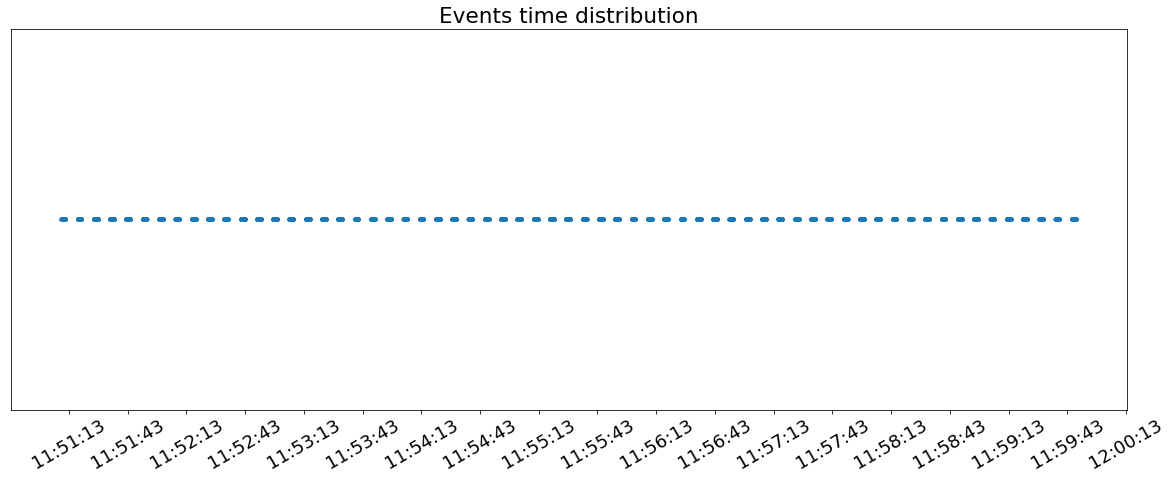

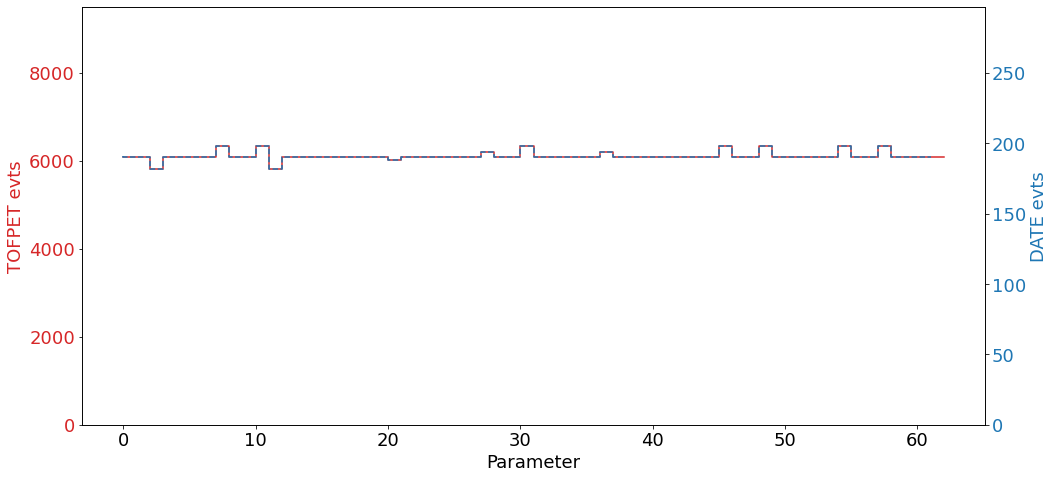

In [7]:
df_counts = process_run(run_number, nbits, field, tofpet_id, channels, plot=True, folder = '/analysis/{run}/hdf5/data/')

In [8]:
df_counts

,channel_id,count,mean,std,min,max,sum,vth_t1
0,0,95,0.000000e+00,0.000000,0,0,0,0
1,1,95,0.000000e+00,0.000000,0,0,0,0
2,2,95,0.000000e+00,0.000000,0,0,0,0
3,3,95,0.000000e+00,0.000000,0,0,0,0
4,4,95,0.000000e+00,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...
59,59,95,4.194304e+06,0.410391,4194300,4194304,398458876,62
60,60,95,4.194304e+06,0.410391,4194300,4194304,398458876,62
61,61,95,4.194304e+06,0.410391,4194300,4194304,398458876,62
62,62,95,4.194304e+06,0.410391,4194300,4194304,398458876,62


**Add columns with data_time and expected_rate for vth_t2**

To calculate the expected rate for each vth_t2, we need to know the total time that has passed to take the measurement. 

This time is calculated knowing that each count in the column "count" is the counter period assigned to the ASIC, in our case
2²² clock cycle and each cycle is 5ns.

Then, the expected rate is calculated as the sum of all counts received divided by the calculated time.

In [9]:
df_counts['data_time']     = (2**22 * 5) / 1e9 * df_counts['count']
df_counts['expected_rate'] = df_counts['sum'] / df_counts['data_time']

In [10]:
# Example of the dataframe produced with the lines above

df_counts[(df_counts['channel_id'] == 60)][0:15]

,channel_id,count,mean,std,min,max,sum,vth_t1,data_time,expected_rate
60,60,95,0.0,0.0,0,0,0,0,1.992294,0.0
60,60,95,0.0,0.0,0,0,0,1,1.992294,0.0
60,60,95,0.0,0.0,0,0,0,2,1.992294,0.0
60,60,91,0.0,0.0,0,0,0,3,1.908408,0.0
60,60,95,0.0,0.0,0,0,0,4,1.992294,0.0
60,60,95,0.0,0.0,0,0,0,5,1.992294,0.0
60,60,95,0.0,0.0,0,0,0,6,1.992294,0.0
60,60,95,0.0,0.0,0,0,0,7,1.992294,0.0
60,60,99,0.0,0.0,0,0,0,8,2.076180,0.0
60,60,95,0.0,0.0,0,0,0,9,1.992294,0.0


In the plots below we show the maximum counts read for each vth_t vs the vth_t that we are calibrating for each channel.

The parameter vth_t is always between 0 and 63. We show first an example:

Text(0, 0.5, 'Entries')

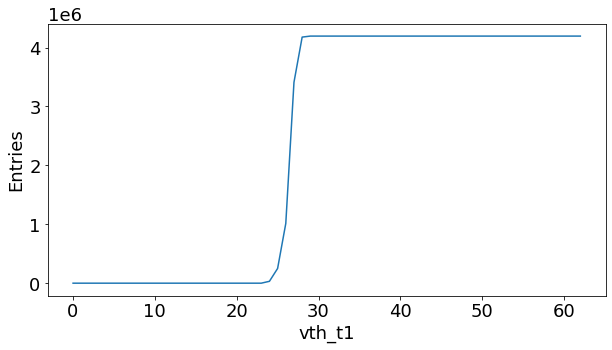

In [11]:
plt.figure(figsize = (10, 5))
plt.plot(df_counts[df_counts['channel_id'] == 0][field].values, df_counts[df_counts['channel_id'] == 0]['max'].values)
plt.xlabel(field)
plt.ylabel('Entries')

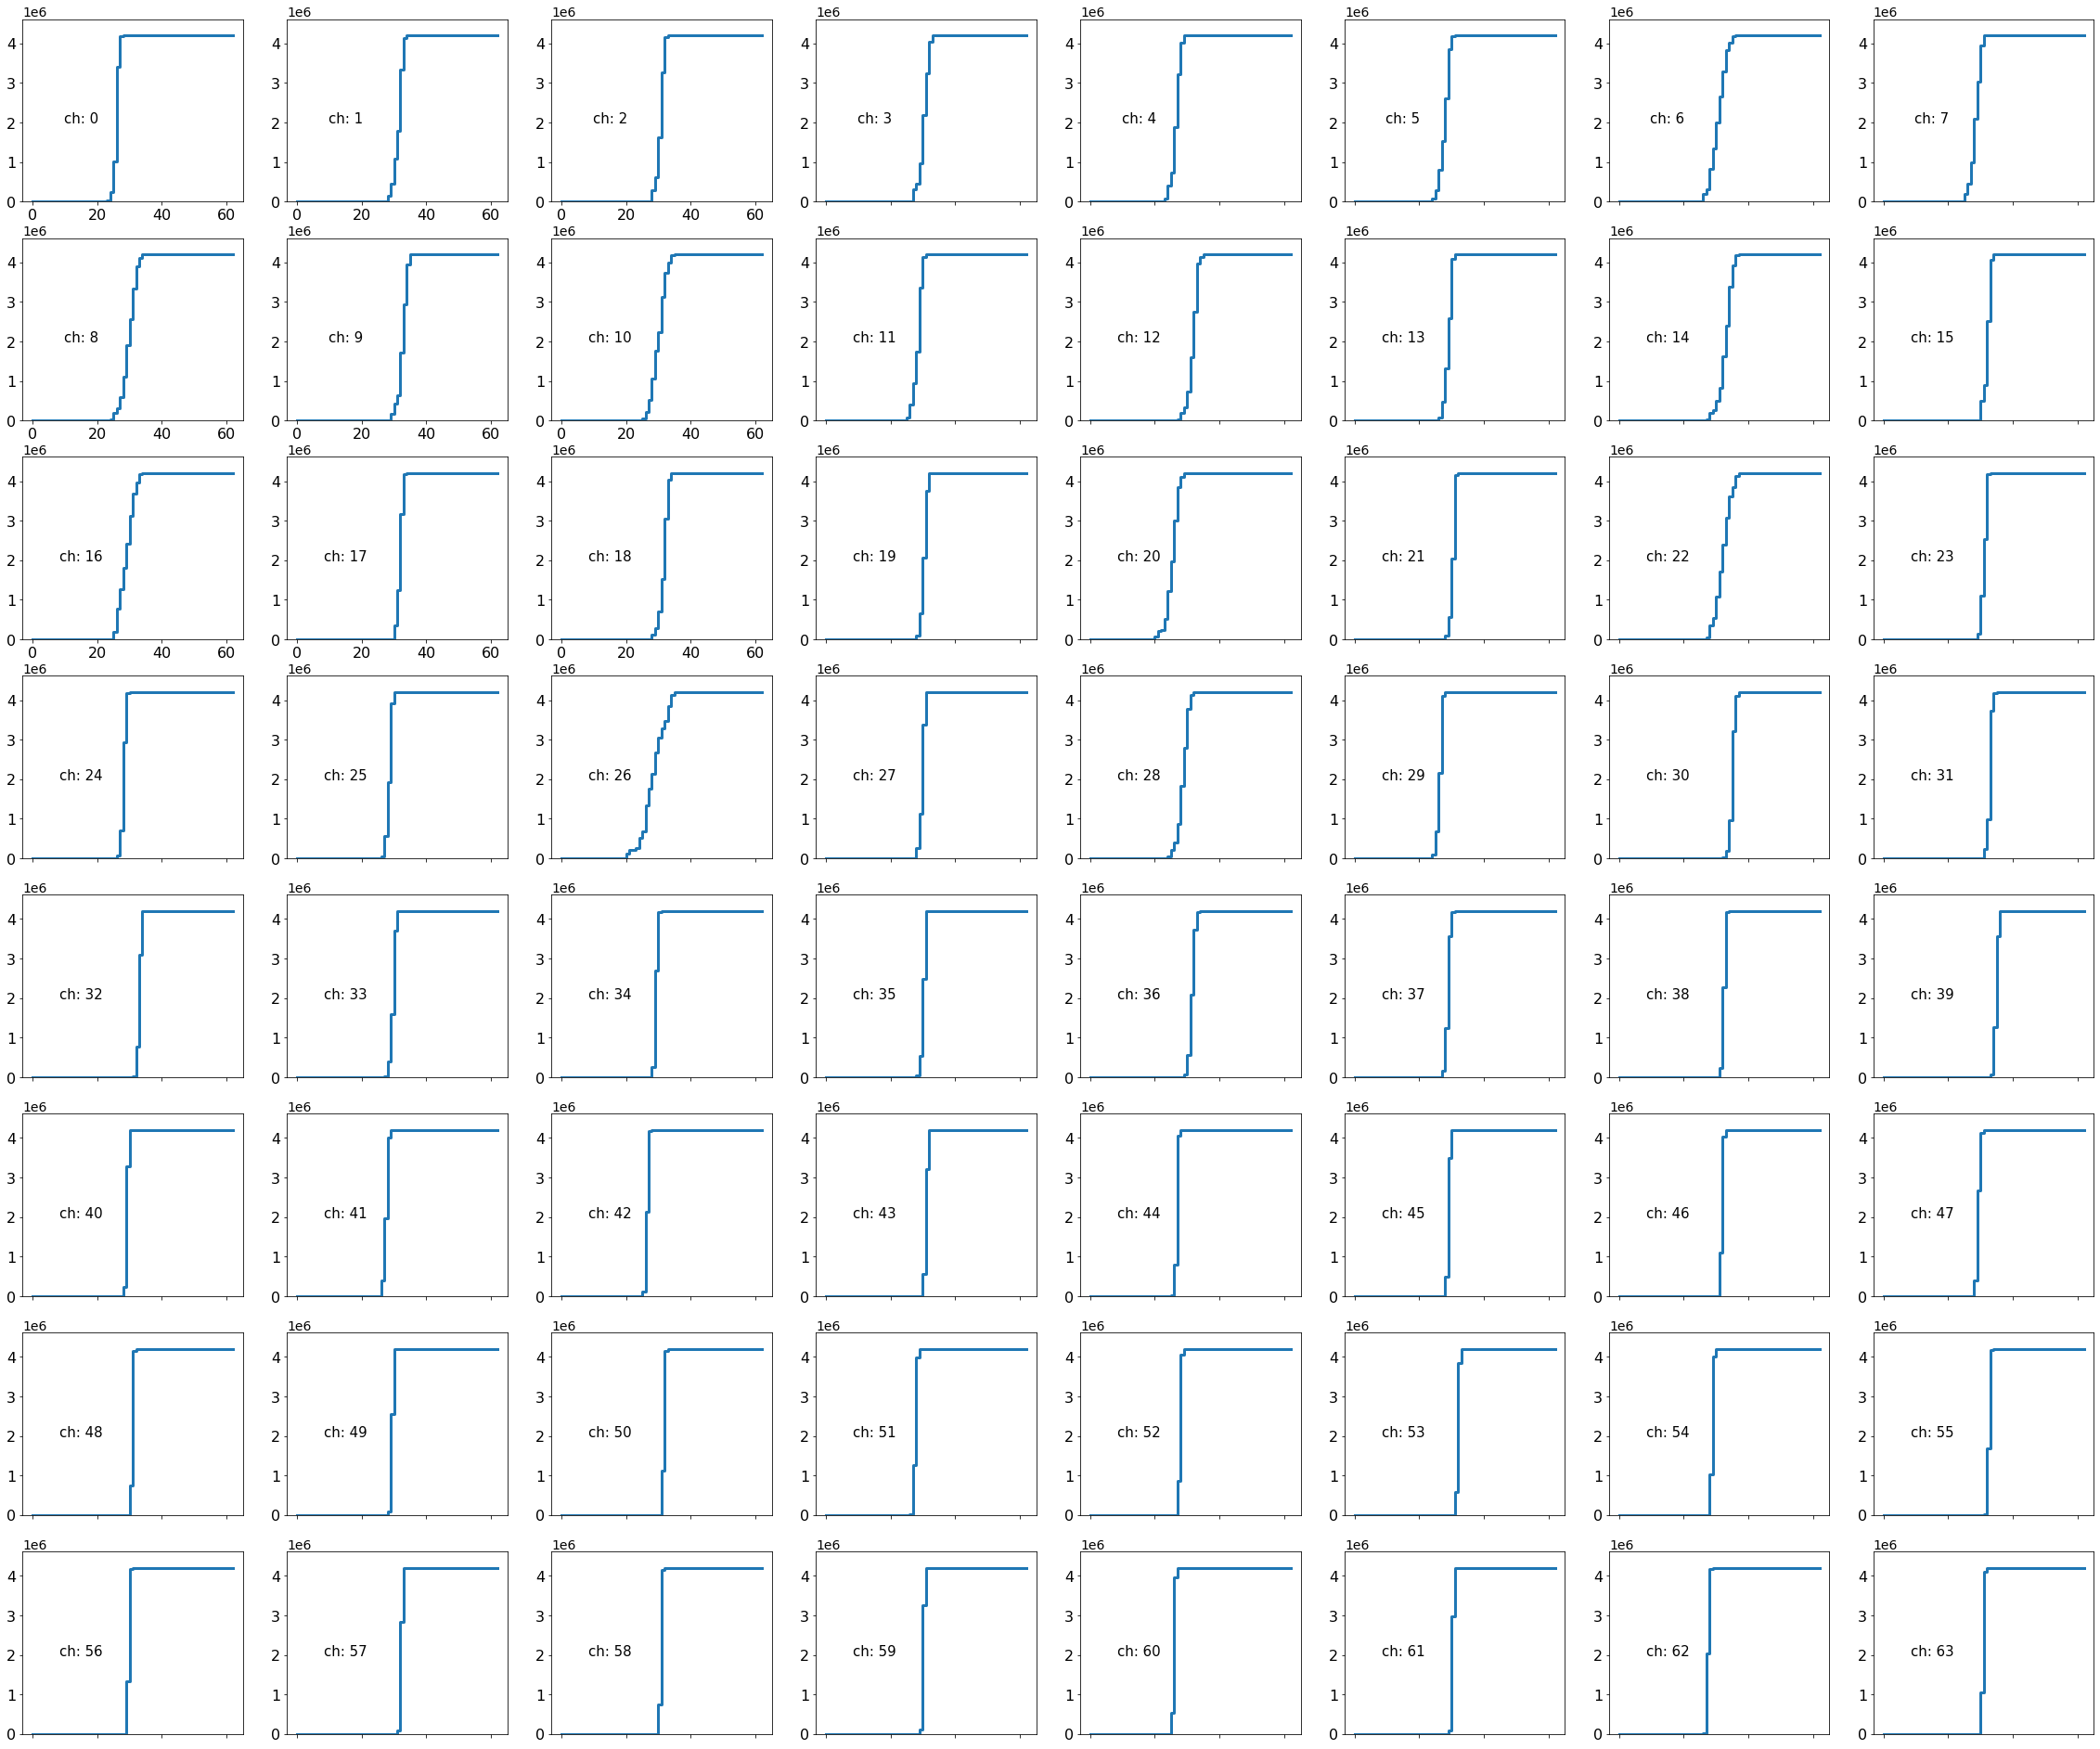

In [12]:
plot_channels(df_counts, channels, nbits)

# Compare several runs

To compare runs, they must always be from the same ASIC and same vth_t.

In [13]:
runs       = {'nbits' : 22, 'asic' : 0, 'run_number' : [11808, 11956]}
field_comp = 'vth_t1'

In [14]:
channels = list(range(64))

In [15]:
def compare_runs(runs, field_comp, channels):
    dfs = []
    for run in runs['run_number']:
        df = process_run(run, runs['nbits'], field_comp, runs['asic'], channels, plot = True)
        dfs.append(df)
    return dfs

In [16]:
def plot_channels_multiple_runs(dfs, runs_dict, channels, title='', fname=None):
    '''
    It plots the channel count from different runs in the same subplot so that it is easier to compare them.
    '''
    runs = runs_dict['run_number']
    nbits = runs_dict['nbits']
    rows = int(len(channels)/8)
    
    #Plot size for different number of channels available
    if len(channels) == 64:
        fig, ax = plt.subplots(figsize=(40,34))
    
    elif len(channels) == 48:
        fig, ax = plt.subplots(figsize=(40,26))
        
    elif len(channels) == 32:
        fig, ax = plt.subplots(figsize=(40,17))    
        
    elif len(channels) == 16:
        fig, ax = plt.subplots(figsize=(40,8))    
    
    colors = iter(['red', 'blue', 'orange', 'green', 'brown', 'yellow'])
    
    for df_counts, run in zip(dfs, runs):
        color = next(colors)
        for i, ch in enumerate(channels):
            values = df_counts[df_counts.channel_id == ch]['max'].values
            ax     = plt.subplot(rows, 8, i+1)
            ymax   = (2**nbits)
            
            plt.plot(values, drawstyle='steps', linewidth=3, color=color, alpha=0.5, label=run)
            plt.ylim(0, 1.1*ymax)
            plt.text(5, 0.5*ymax, f"ch: {ch}", horizontalalignment='center', verticalalignment='center', rotation=0, fontsize=13)
            
            max_label = '2^{{{}}}'.format(nbits)
            ax.set_yticks([0, 2**nbits])
            ax.set_yticklabels(['$0$', f'${max_label}$'])
            plt.setp(ax.get_yticklabels(), fontsize=14)
            
            if i in [0, 1, 2, 8, 9, 10, 16, 17, 18]:
                plt.setp(ax.get_xticklabels(), fontsize=18)
            else:
                plt.setp(ax.get_xticklabels(), visible=False)
    
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(bbox_to_anchor=(1.5, rows + 1.3))
    plt.suptitle(title)
    fig.tight_layout()
    
    if fname:
        plt.savefig(fname)

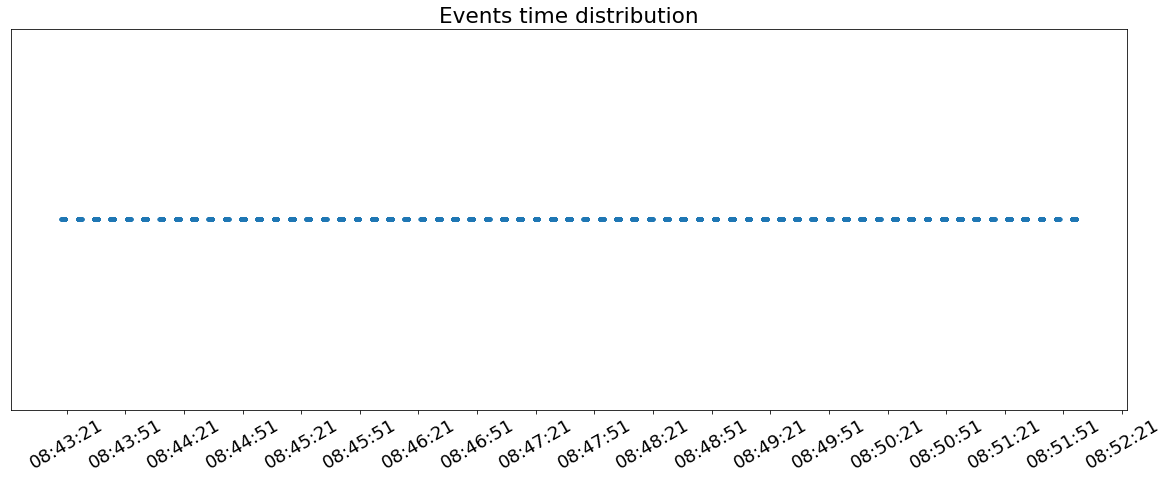

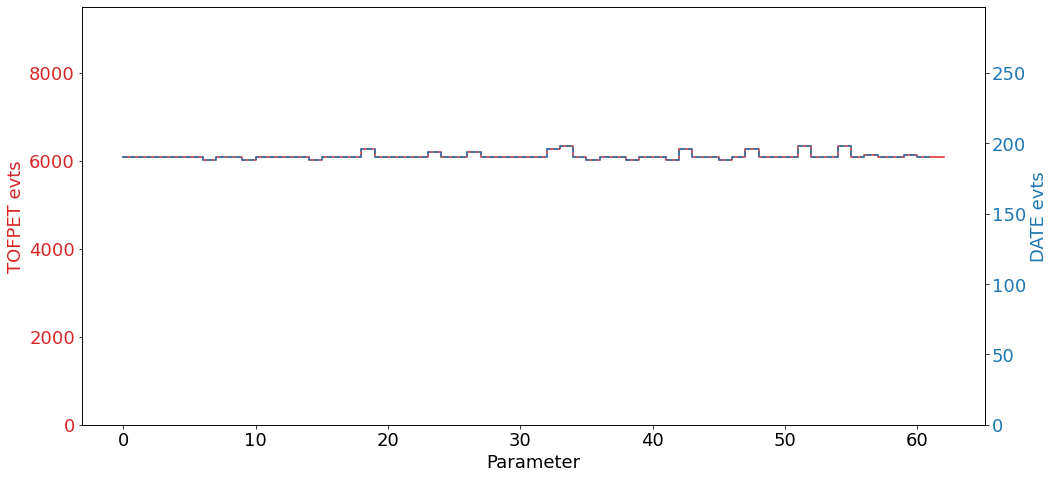

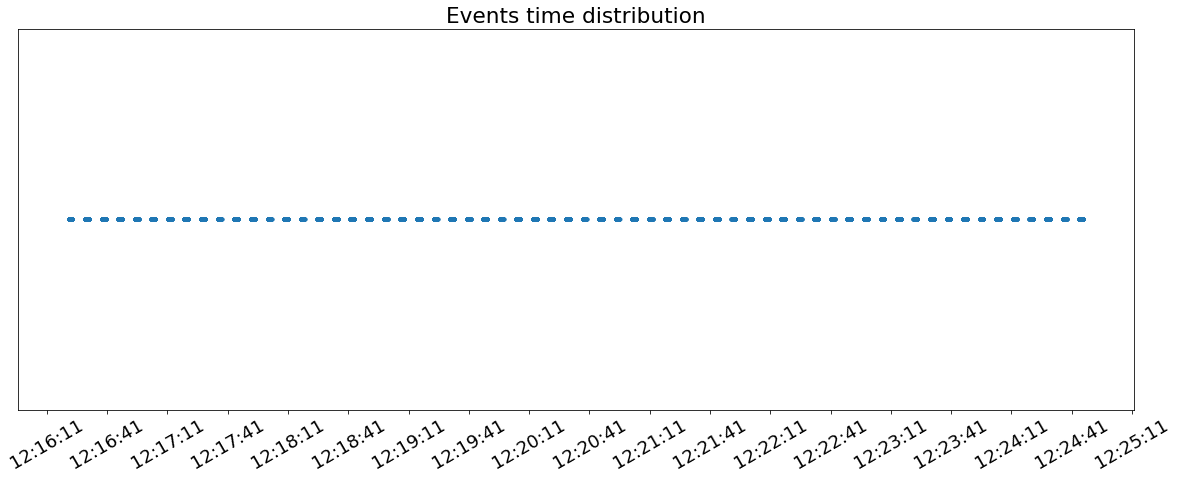

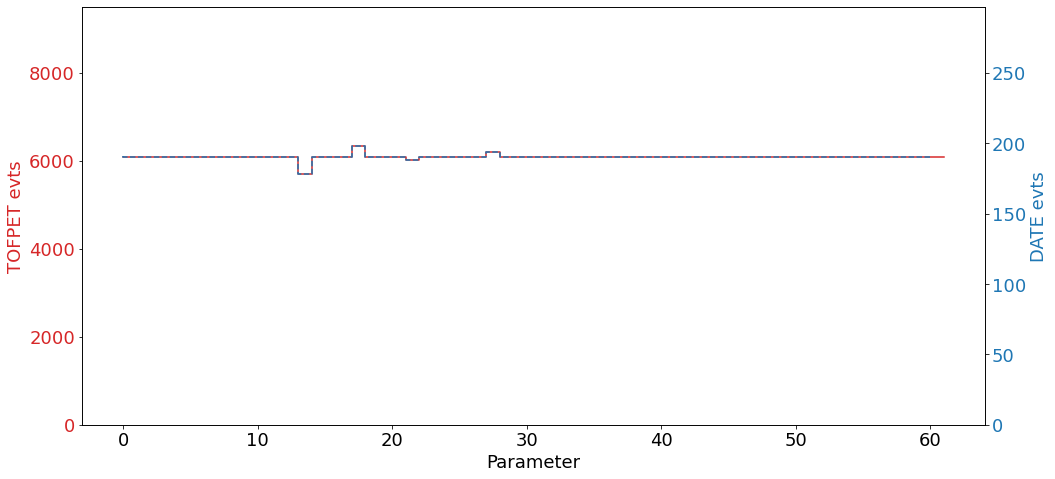

In [17]:
dfs = compare_runs(runs, field_comp, channels)

In [18]:
dfs

[    channel_id  count          mean       std      min      max        sum  \
 0            0     95  0.000000e+00  0.000000        0        0          0   
 1            1     95  0.000000e+00  0.000000        0        0          0   
 2            2     95  0.000000e+00  0.000000        0        0          0   
 3            3     95  0.000000e+00  0.000000        0        0          0   
 4            4     95  0.000000e+00  0.000000        0        0          0   
 ..         ...    ...           ...       ...      ...      ...        ...   
 59          59     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 60          60     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 61          61     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 62          62     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 63          63     95  4.194304e+06  0.410391  4194300  4194304  398458876   
 
     vth_t1  
 0        0  
 1        0  
 2      

**Add columns with data_time and expected_rate for vth_t2**

In [19]:
dfs[0]['data_time'] = (2**22 * 5) / 1e9 * dfs[0]['count']
dfs[0]['expected_rate'] = dfs[0]['sum'] / dfs[0]['data_time']

dfs[1]['data_time'] = (2**22 * 5) / 1e9 * dfs[1]['count']
dfs[1]['expected_rate'] = dfs[1]['sum'] / dfs[1]['data_time']

As above, we represent the maximum counts read for each vth_t vs the vth_t that we are calibrating for each channel, and for two different runs.

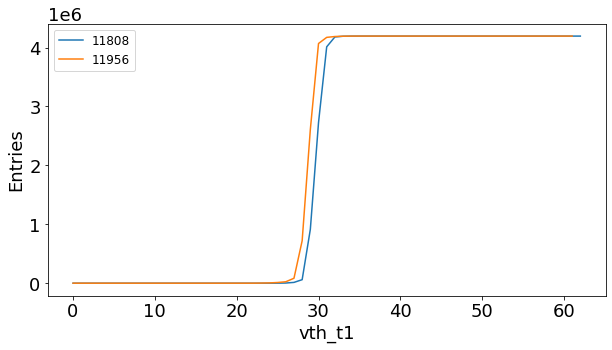

In [20]:
plt.figure(figsize = (10, 5))
plt.plot(dfs[0][dfs[0]['channel_id'] == 0][field].values, dfs[0][dfs[0]['channel_id'] == 0]['max'].values, label = runs['run_number'][0])
plt.plot(dfs[1][dfs[1]['channel_id'] == 0][field].values, dfs[1][dfs[1]['channel_id'] == 0]['max'].values, label = runs['run_number'][1])
plt.xlabel(field)
plt.ylabel('Entries')
plt.legend(fontsize = 12)

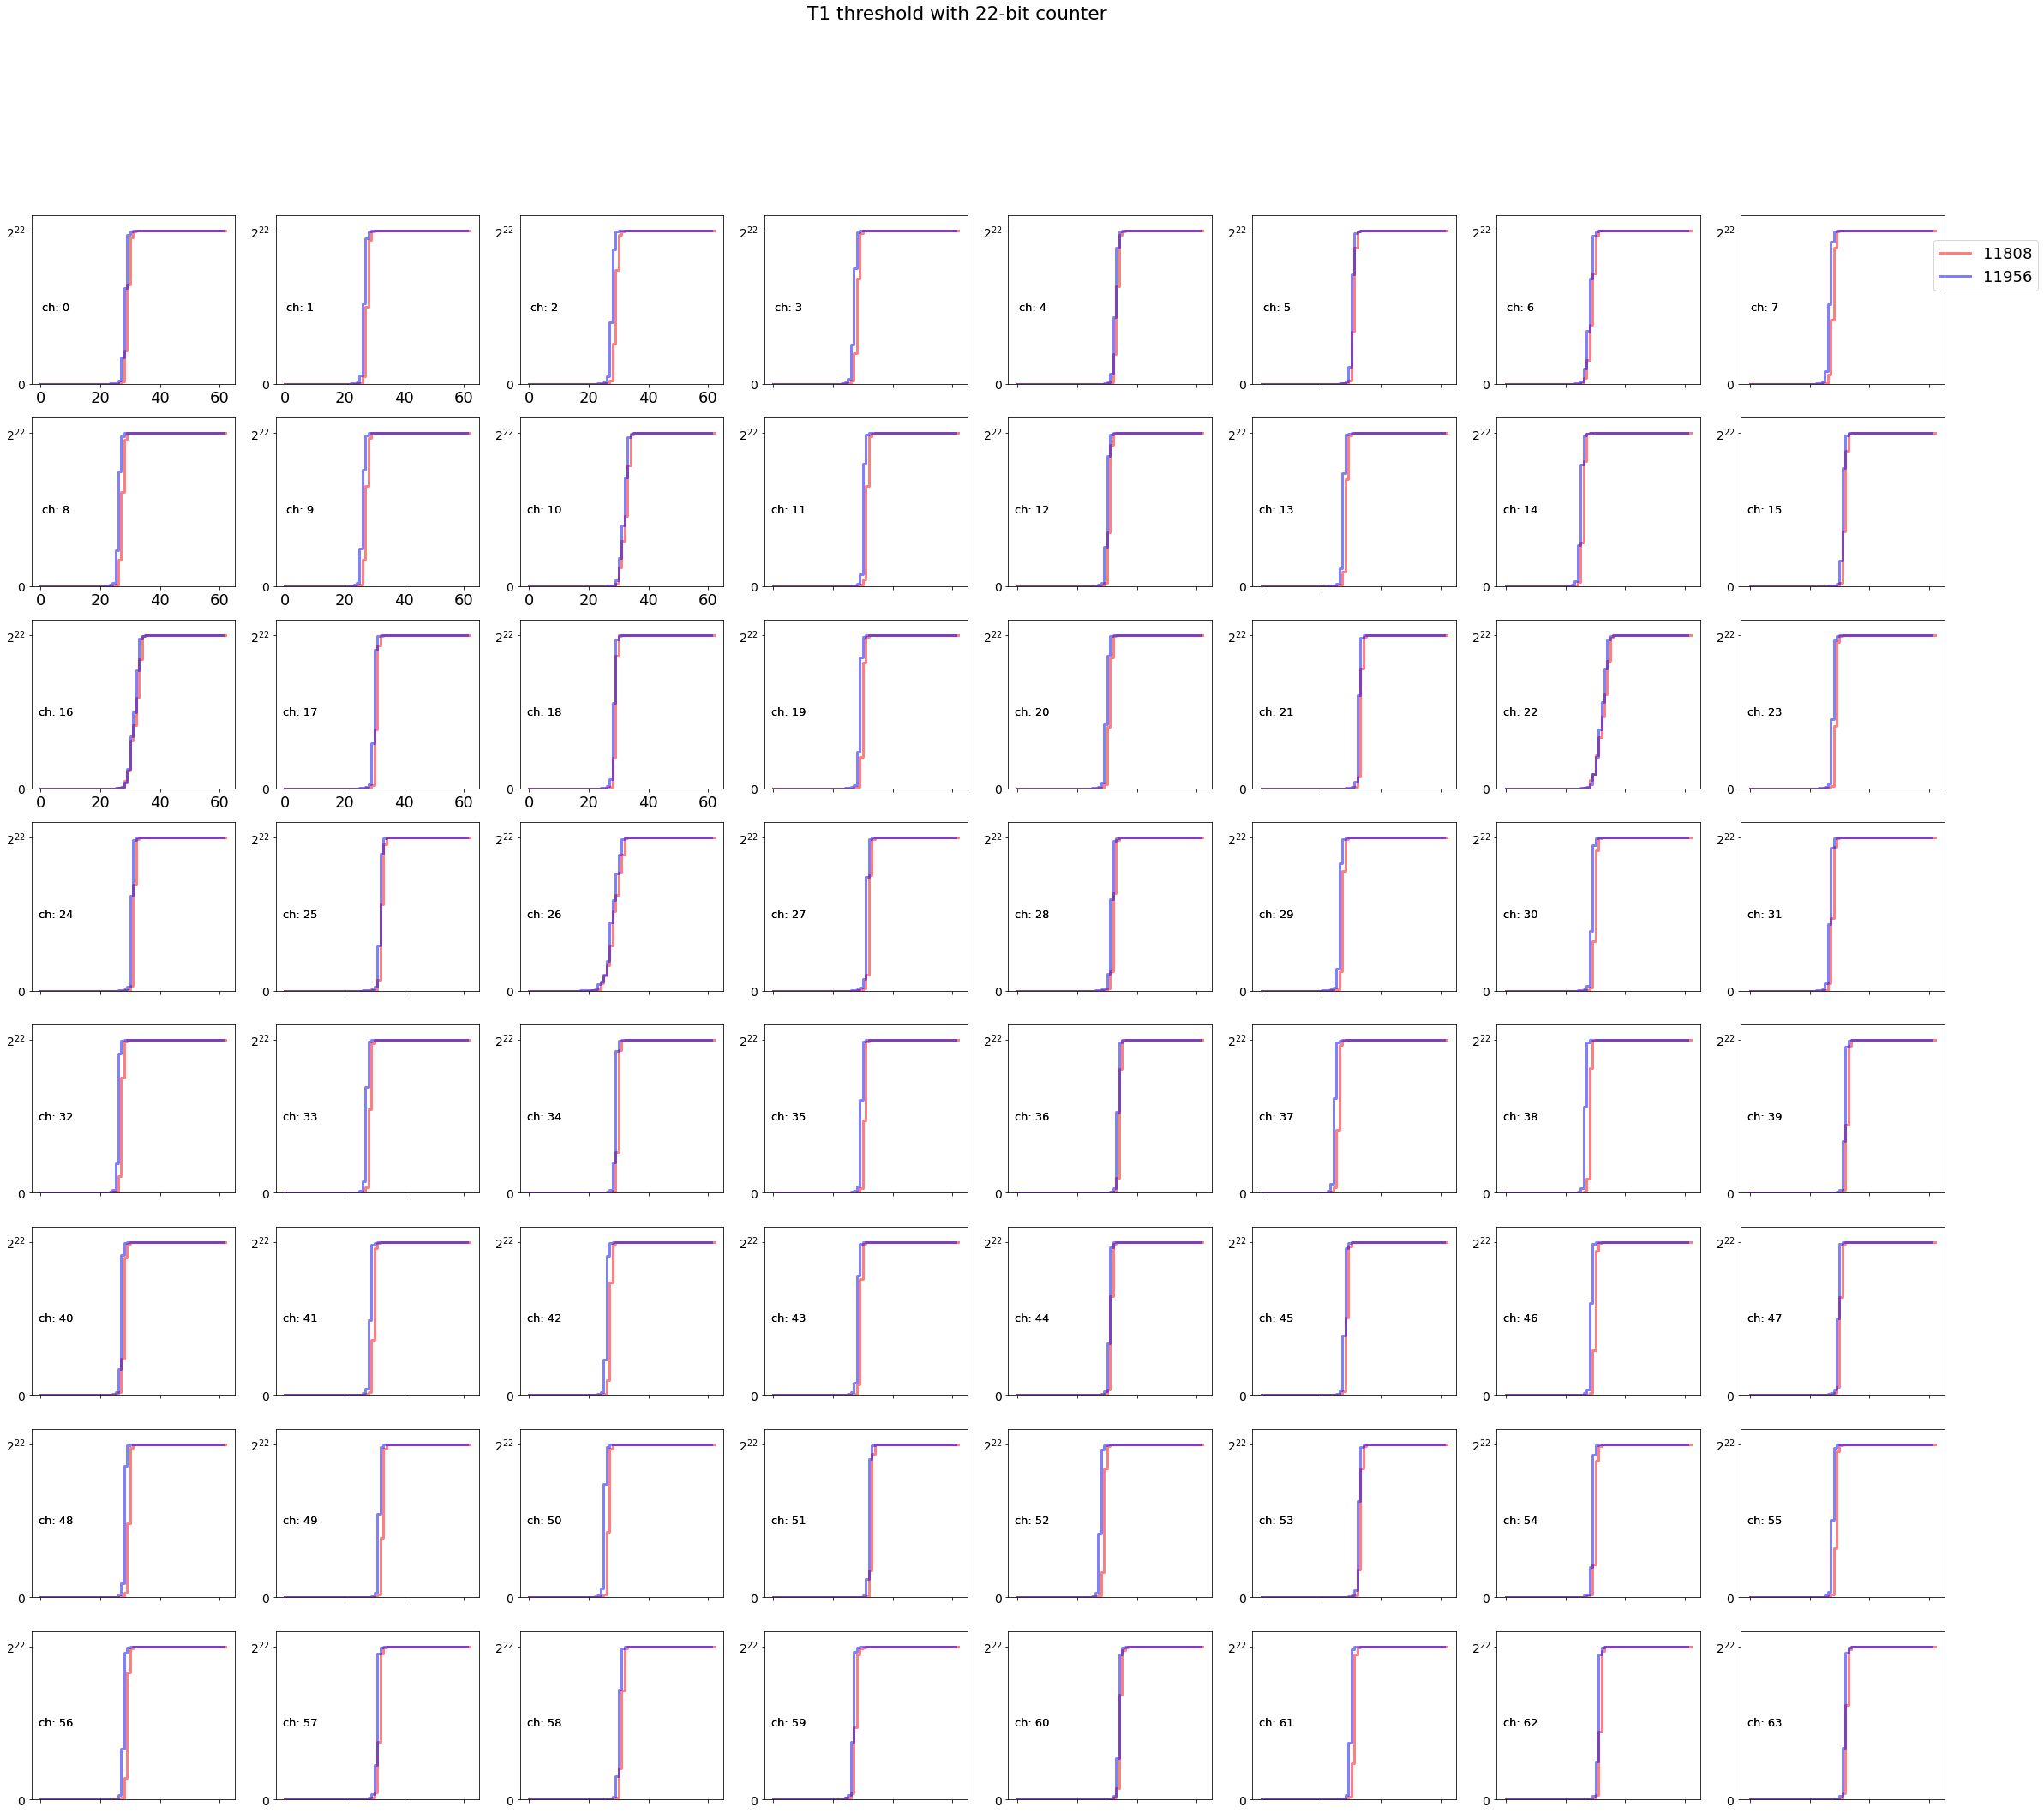

In [21]:
plot_channels_multiple_runs(dfs, runs, channels, title="T1 threshold with 22-bit counter")

# Find threshold vth_t1 and vth_t2

In [22]:
vth_t = find_threshold(df_counts, nbits, field, 20) # if field = vth_t2, 4th argument (activity) is needed in Hz
vth_t

array([23., 27., 27., 26., 23., 23., 24., 24., 23., 28., 24., 24., 27.,
       25., 27., 29., 23., 29., 27., 27., 19., 27., 26., 28., 25., 25.,
       17., 27., 23., 23., 31., 30., 31., 27., 27., 27., 28., 26., 30.,
       32., 27., 25., 24., 29., 25., 27., 30., 27., 29., 27., 30., 26.,
       26., 30., 27., 31., 28., 30., 29., 28., 24., 28., 26., 29.])

**Dictionary for data acquisition program:**

In [23]:
ts = {}

for i in range(64):
    
        ts[i]= int(vth_t[i])
ts

{0: 23,
 1: 27,
 2: 27,
 3: 26,
 4: 23,
 5: 23,
 6: 24,
 7: 24,
 8: 23,
 9: 28,
 10: 24,
 11: 24,
 12: 27,
 13: 25,
 14: 27,
 15: 29,
 16: 23,
 17: 29,
 18: 27,
 19: 27,
 20: 19,
 21: 27,
 22: 26,
 23: 28,
 24: 25,
 25: 25,
 26: 17,
 27: 27,
 28: 23,
 29: 23,
 30: 31,
 31: 30,
 32: 31,
 33: 27,
 34: 27,
 35: 27,
 36: 28,
 37: 26,
 38: 30,
 39: 32,
 40: 27,
 41: 25,
 42: 24,
 43: 29,
 44: 25,
 45: 27,
 46: 30,
 47: 27,
 48: 29,
 49: 27,
 50: 30,
 51: 26,
 52: 26,
 53: 30,
 54: 27,
 55: 31,
 56: 28,
 57: 30,
 58: 29,
 59: 28,
 60: 24,
 61: 28,
 62: 26,
 63: 29}